<a href="https://colab.research.google.com/github/ryu-i-engineer/ImageAnnotationChallenge/blob/main/notebooks/ImageAnnotationChallenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ImageAnnotationChallenge

## Overview : 概要

### Project target : プロジェクト目標

- 普通のECサイトにおける検索機能について､改善方法を検討する
- 画像認識によるタグ付けの開発を優先する
- メンバーも実際のプロジェクト経験をもらいつつ､デモプロジェクトの開発と記事を作成できるまで頑張る

In English:
- Consider the ways how to improve search function on e-commerce site.
- Prioritize the development of tagging by image recognition.
- The members will do our best until creating an article and developing demo project, gaining project experience.


### Study scope : 学習範囲

* Note記事を書く
* 画像認識によるタグ付けを優先して開発する
* 日本語･英語両方タグ付けできるようにする

In English:

* Write a note article
* Develop tagging system by image recognition in priority
* The system becomes able to tag  in Japanese and English


### Repository

* [TOP](https://github.com/ryu-i-engineer/ImageAnnotationChallenge)
* [Projects](https://github.com/ryu-i-engineer/ImageAnnotationChallenge/projects/2)

## Reference

- https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub
- https://www.tensorflow.org/tutorials/images/segmentation

### About Transfer learning

#### Domain problem

- [転移学習：機械学習の次のフロンティアへの招待](https://qiita.com/icoxfog417/items/48cbf087dd22f1f8c6f4#%E8%BB%A2%E7%A7%BB%E5%AD%A6%E7%BF%92%E3%81%AE%E5%8F%96%E3%82%8A%E7%B5%84%E3%82%80%E5%95%8F%E9%A1%8C)

## Dataset

### Using web scraping

From here.
- https://jp.misumi-ec.com/vona2/mech_screw/M3303000000/?rid=c21_top_4_M3303000000

In [ ]:
import os
import seaborn as sns
import pandas as pd

misumi_dataset_path = "./inputs/misumi_dataset_cleansing"

label_names = []
label_file_counts = []

for dir_name in os.listdir(misumi_dataset_path):
    label_names.append(dir_name)
    label_file_counts.append(len([filename for filename in os.listdir(os.path.join(misumi_dataset_path, dir_name)) if os.path.isfile(os.path.join(misumi_dataset_path, dir_name, filename))]))
    

In [ ]:
d = {'Labels' : label_names, 'File counts': label_file_counts}
misumi_df = pd.DataFrame(d)
misumi_df.describe()

,File counts
count,134.000000
mean,87.089552
std,170.999559
min,2.000000
25%,17.000000
50%,40.000000
75%,86.750000
max,1491.000000


### Dummy data

- 3D
- CAD
- Items should not be there.
- Utilities something like "Accessories" and "Components"

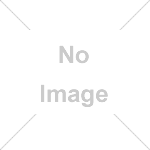
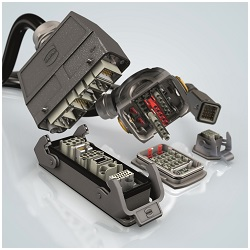
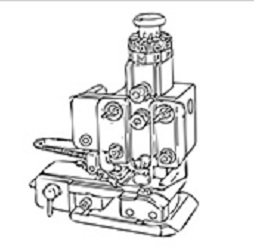
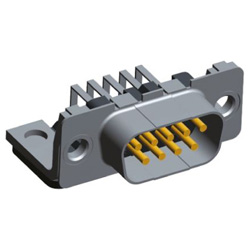

### Define lables and binarize

#### CSV format

```csv
"directory","filename","tag1","tag2","tag3","tag4","tag5","tag6","tag7","tag8","tag9","tag10"
"nuts","test.jpg","nuts","metal","hex",
"bolts","test2.jpg","nuts","non-metal","screws","flat"
```

#### Code

In [1]:
import pandas as pd
df = pd.read_csv("./inputs/fasteners/fasteners_label.csv")
df.dropna(axis=1, how="all")

,directory,filename,tag1,tag2,tag3,tag4,tag5,tag6,tag7,tag8,tag9,tag10,tag11,tag12,tag13
0,screw,000000.jpg,Silver,Internal Head,Square Head,Bugle Head,Stainless Steel,Deck Screw,Coarse,NaN,NaN,NaN,NaN,NaN,NaN
1,screw,000001.jpg,Silver,Internal Head,Square Head,Bugle Head,Stainless Steel,Deck Screw,Coarse,NaN,NaN,NaN,NaN,NaN,NaN
2,screw,000002.jpg,Silver,Internal Head,Square Head,Bugle Head,Stainless Steel,Deck Screw,Coarse,NaN,NaN,NaN,NaN,NaN,NaN
3,screw,000003.jpg,Blue,Phillips Head,Flat Head,Carbon Steel,Masonry Anchor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,screw,000004.jpg,Blue,Phillips Head,Flat Head,Carbon Steel,Masonry Anchor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3793,screw,003987.jpg,Burgundy,External Head,Hex Head,Hex Head,Washer Head,Steel,Roofing Screw,Hi-Lo,NaN,NaN,NaN,NaN,NaN
3794,screw,003988.jpg,Burgundy,External Head,Hex Head,Hex Head,Washer Head,Steel,Roofing Screw,Hi-Lo,NaN,NaN,NaN,NaN,NaN
3795,screw,003989.jpg,Bronze,External Head,Hex Head,Hex Head,Washer Head,Steel,Roofing Screw,Hi-Lo,NaN,NaN,NaN,NaN,NaN
3796,screw,003990.jpg,Bronze,External Head,Hex Head,Hex Head,Washer Head,Steel,Roofing Screw,Hi-Lo,NaN,NaN,NaN,NaN,NaN


In [2]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

df = df.dropna(axis=1, how='all') # save memory and process usage
df = df.fillna('None') # to avoid error

result = mlb.fit_transform( df.drop(columns=['directory', 'filename']).values) # drop not tagging cols

bin_df = pd.DataFrame(result, columns=mlb.classes_).drop('None', axis=1) # drop non-useless col.
bin_df = df.join(bin_df).drop(["tag1", "tag2", "tag3", "tag4", "tag5", "tag6", "tag7", "tag8","tag9", "tag10", "tag11","tag12", "tag13"], axis=1)
bin_df.head()

,directory,filename,6 Lobe Head,Allen,Aluminum,Binding,Black,Blue,Bolt,Brass,...,Timber Bolt,Torx 6 Lobe Screw,Trim,Truss Head,"Truss Head""",Washer Head,White,Wood Screw,Yellow,Zinc Plated Steel
0,screw,000000.jpg,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,screw,000001.jpg,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,screw,000002.jpg,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,screw,000003.jpg,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,screw,000004.jpg,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# get tag list
bin_df.drop(['directory', 'filename'], axis=1).columns.to_list()

['6 Lobe Head',
 'Allen',
 'Aluminum',
 'Binding',
 'Black',
 'Blue',
 'Bolt',
 'Brass',
 'Bronze',
 'Brown',
 'Bugle Head',
 'Burgundy',
 'Button Head',
 'Cap Screw',
 'Carbon Steel',
 'Carriage Bolt',
 'Charcoal',
 'Coarse',
 'Deck Screw',
 'Dome Head',
 'Dowel Screw',
 'Drywall Screw',
 'External Head',
 'Fillister',
 'Fine',
 'Flange Head',
 'Flat Head',
 'Framing Drywall Screw',
 'Framing Self Drilling Drywall Screw',
 'Fully Threaded Head',
 'Gray',
 'Green',
 'Hanger Bolt',
 'Hex Head',
 'Hi-Lo',
 'Indented Truss',
 'Internal Head',
 'Ivory',
 'Knurled Head',
 'Lag Screw',
 'Laminating Drywall Screw',
 'Lath Screw',
 'Machine Screw',
 'Machine Screw Anchor Set Tool',
 'Masonry Anchor',
 'Modified Truss',
 'No Head',
 'Non-Serrated Flange Bolt',
 'One Way Head',
 'Oval Head',
 'Oversize Truss',
 'Pan Head',
 'Pancake Head',
 'Phillips Head',
 'Plow Bolt',
 'Red',
 'Roofing Screw',
 'Round Head',
 'SEMS Machine Screw',
 'Sammy Rod Hanger Anchors',
 'Self Drilling Drywall Screw',
 

#### Tag list

See also,
- [Fasterner(wiki)](https://en.wikipedia.org/wiki/Fastener)
- [Nuts(wiki)](https://en.wikipedia.org/wiki/Nut_(hardware))
- [Wahser(wiki)](https://en.wikipedia.org/wiki/Washer_(hardware))
- [Electrical cable(wiki)](https://en.wikipedia.org/wiki/Electrical_cable)

##### Components


- accessories
- caps
- cables
- connector
- conduits
- bolts
- ducts
- fully-threaded
- image_seonsor
- io_board
- mount
- nuts
- pins
- rings
- screws
- tape
- tie
- tools
- washer
- wire

##### Materials


- metal
- nylon
- plastic
- celamic

##### Shapes

- ac_servo
- av_antenna
- audio_video
- branching
- clinching
- clip
- crimp
- cylindrical
- display
- domed
- eye_screws
- fiber_optic
- flanged
- flat
- gauge
- hex
- high
- inserts
- knurled
- lan
- lock
- machine_keys
- micro
- precise
- printer
- ps2
- rectangular
- rivet
- rc232
- scsi
- slot
- spacer
- thumb_ornamental
- usb
- wing
- weld

## Codes

### Using TF Hub for Transfer learning

#### Prepare

In [4]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

import datetime

In [42]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [43]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12428958699026417367
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4853137408
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15299635210368823934
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [71]:
# Download classification
# classifier_url = "https://tfhub.dev/google/imagenet/resnet_v2_152/classification/5" # ResNet-152
# classifier_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/classification/2" # EfficientNet V2

mobilenet_v2 ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"

# classifier_model = mobilenet_v2

In [ ]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(mobilenet_v2, input_shape=IMAGE_SHAPE+(3,))
])

#### Execute one image file

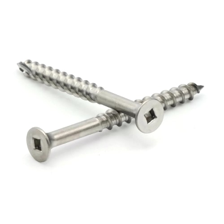

In [ ]:
import numpy as np
import PIL.Image as Image

# grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
# grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
# grace_hopper = Image.open("./inputs/misumi_dataset/ac_servo_motor_cables/000001.jpg").resize(IMAGE_SHAPE)
grace_hopper = Image.open("./inputs/fasteners/screw/000001.jpg").resize(IMAGE_SHAPE)
grace_hopper

In [ ]:
# Get batch dimension and input image to model.
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [ ]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

In [ ]:
predicted_class = tf.math.argmax(result[0], axis=-1)
predicted_class

<tf.Tensor: shape=(), dtype=int64, numpy=513>

#### Decode the predict result

In [ ]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

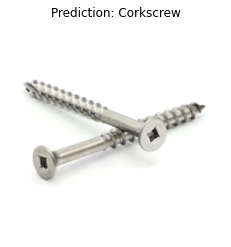

In [ ]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

In [ ]:
# data_root = tf.keras.utils.get_file(
#   'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
#    untar=True)

data_root = "./inputs/fasteners"

In [ ]:
import pandas as pd
pd.read_csv('./inputs/fasteners/fasteners_label.csv').dropna(axis=1, how='all')

,directory,filename,tag1,tag2,tag3,tag4,tag5,tag6,tag7,tag8
0,screw,000000.jpg,Silver,Internal Square,Bugle,Stainless Steel,Deck Screw,Coarse,NaN,NaN
1,screw,000001.jpg,Silver,Internal Square,Bugle,Stainless Steel,Deck Screw,Coarse,NaN,NaN
2,screw,000002.jpg,Silver,Internal Square,Bugle,Stainless Steel,Deck Screw,Coarse,NaN,NaN
3,screw,000003.jpg,Blue,Phillips,Flat,Carbon Steel,Masonry Anchor,NaN,NaN,NaN
4,screw,000004.jpg,Blue,Phillips,Flat,Carbon Steel,Masonry Anchor,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
4620,nut,000396.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4621,nut,000397.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4622,nut,000398.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4623,nut,000399.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

df = pd.read_csv('./inputs/fasteners/fasteners_label.csv')
df = df.dropna(axis=1, how='all') # save memory and process usage

result = mlb.fit_transform(df.fillna('None').drop(columns=['directory', 'filename']).values) # drop not tagging cols

bin_df = pd.DataFrame(result, columns=mlb.classes_) # drop non-useless col.

In [ ]:
labels = bin_df.columns
labels

Index([' 1022 Carbon Steel', ' 18-8 Stainless Steel', ' Acorn', ' Acorn Nut',
       ' Aluminum', ' Beveled Square Washer', ' Binding', ' Black', ' Blue',
       ' Brass',
       ...
       ' Well Nut', ' White', ' Wing Nut', ' Wood Screw', ' Yellow', ' Zinc',
       ' Zinc Plated Steel', 'Hex', 'Internal Square', 'None'],
      dtype='object', length=224)

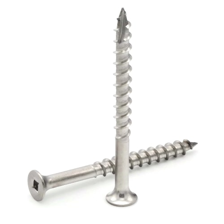

In [ ]:
import os
Image.open(os.path.join(data_root, df['directory'][0], df.filename[0])).resize(IMAGE_SHAPE)

In [ ]:
image_list = [os.path.join(data_root, row.directory, row.filename) for row in df.loc[:, 'directory':'filename'].itertuples()]

In [ ]:
data = []
for image_path in image_list:
    img = tf.image.decode_jpeg(tf.io.read_file(image_path), channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    data.append(tf.image.resize(img, IMAGE_SHAPE))

In [ ]:
data = np.array(data, dtype="float")/255

In [ ]:
from sklearn.model_selection import train_test_split
trainX, valX, trainY, valY = train_test_split(data, bin_df.to_numpy(), test_size=0.2, random_state=42)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 4625 files belonging to 3 classes.
Using 3700 files for training.
Found 4625 files belonging to 3 classes.
Using 925 files for validation.


In [ ]:
class_names = np.array(train_ds.class_names)
print(f"This datasets has {len(class_names)} classes.")

This datasets has 3 classes.


In [ ]:
# add normalization layer
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

In [ ]:
# avoid I/O blocking issues
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


#### Download headless model

In [ ]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
effienct_v2 = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_s/classification/2"

feature_extractor_model = mobilenet_v2

In [ ]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False
)

In [ ]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

#### Attach a classification head

In [ ]:
len(bin_df.to_numpy())

4625

In [ ]:
num_classes = bin_df.to_numpy().shape[1]

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SHAPE+(3,)),
    feature_extractor_layer,
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(num_classes, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(num_classes, activation='sigmoid')
])
model.build((None,)+IMAGE_SHAPE+(3,))

In [ ]:
predictions = model(image_batch)
predictions.shape

TensorShape([32, 3])

#### Train model

In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Nadam(learning_rate=0.0005),
  loss=tf.keras.losses.BinaryCrossentropy(),
  metrics=[tf.keras.metrics.BinaryAccuracy()])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 224)               286944    
_________________________________________________________________
dropout_1 (Dropout)          (None, 224)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 224)               50400     
Total params: 2,595,328
Trainable params: 337,344
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
print(trainX.shape)
print(trainY.shape)

(3700, 224, 224, 3)
(3700, 224)


In [ ]:
NUM_EPOCHS = 50

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.001, patience=3
)

history = model.fit(x=aug.flow(trainX, trainY, batch_size=32),
                    validation_data=(valX, valY),
                    epochs=NUM_EPOCHS,
                    steps_per_epoch=len(trainX) // 32,
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/50
115/115 [==============================] - 39s 293ms/step - loss: 0.1482 - binary_accuracy: 0.9434 - val_loss: 0.0666 - val_binary_accuracy: 0.9803
Epoch 2/50
115/115 [==============================] - 32s 279ms/step - loss: 0.0748 - binary_accuracy: 0.9781 - val_loss: 0.0664 - val_binary_accuracy: 0.9803
Epoch 3/50
115/115 [==============================] - 33s 290ms/step - loss: 0.0720 - binary_accuracy: 0.9788 - val_loss: 0.0659 - val_binary_accuracy: 0.9803
Epoch 4/50
115/115 [==============================] - 32s 279ms/step - loss: 0.0703 - binary_accuracy: 0.9791 - val_loss: 0.0658 - val_binary_accuracy: 0.9803


In [ ]:
predictions = model.predict(valX)

#### Visualization of model training history

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#### Result

In [ ]:
from textwrap import wrap
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n].numpy() == labels_batch[n].numpy() else "red"
  plt.title('\n'.join(wrap(predicted_label_batch[n].title(), 15)), color=color, fontsize=10)
  plt.axis('off')
_ = plt.suptitle("Model predictions")

#### Export model

In [29]:
from datetime import date

export_path = f"./models/{date.today().isoformat()}_{str(int(time.time()))}"
model.save(export_path, save_format='tf')

export_path

INFO:tensorflow:Assets written to: ./models/2021-10-31_1635610444\assets


INFO:tensorflow:Assets written to: ./models/2021-10-31_1635610444\assets


'./models/2021-10-31_1635610444'

In [ ]:
# import os
# # os.listdir("./models/")
# print(len(next(os.walk('./models/'))[1]))

2


In [ ]:
# reloaded = tf.keras.models.load_model(export_path)

In [ ]:
# result_batch = model.predict(image_batch)
# reloaded_result_batch = reloaded.predict(image_batch)

In [ ]:
# abs(reloaded_result_batch - result_batch).max()

# Multi Label

In [5]:
LABELS = bin_df.columns[2:].to_list()
LABELS[:5]

['6 Lobe Head', 'Allen', 'Aluminum', 'Binding', 'Black']

In [6]:
import glob, os
data_dir = "./inputs/fasteners/screw"
filenames = glob.glob(os.path.join(data_dir, "*.jpg"))

In [7]:
ds_size = len(filenames)
print("Number of images in folders: ", ds_size)

number_of_selected_samples = 3798
filelist_ds = tf.data.Dataset.from_tensor_slices(filenames[:number_of_selected_samples])

ds_size=filelist_ds.cardinality().numpy()
print("Number of selected samples for dataset: ", ds_size)

Number of images in folders:  3798
Number of selected samples for dataset:  3798


In [8]:
filenames[:5]

['./inputs/fasteners/screw\\000000.jpg',
 './inputs/fasteners/screw\\000001.jpg',
 './inputs/fasteners/screw\\000002.jpg',
 './inputs/fasteners/screw\\000003.jpg',
 './inputs/fasteners/screw\\000004.jpg']

In [9]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  file_name= parts[-1]
#   labels= bin_df[bin_df["filename"]==file_name][LABELS].to_numpy().squeeze()
  return tf.squeeze(bin_df[bin_df['filename']==file_name][LABELS])

In [10]:
IMG_WIDTH, IMG_HEIGHT = 224 , 224
def decode_img(img):
  #color images
  img = tf.image.decode_jpeg(img, channels=3) 
  #convert unit8 tensor to floats in the [0,1]range
  img = tf.image.convert_image_dtype(img, tf.float32) 
  #resize 
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [11]:
def combine_images_labels(file_path: tf.Tensor):
  label = get_label(file_path)
  label = tf.cast(label, tf.int64)
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [12]:
train_ratio = 0.80
ds_train=filelist_ds.take(ds_size*train_ratio)
ds_test=filelist_ds.skip(ds_size*train_ratio)

In [13]:
BATCH_SIZE = 224

In [14]:
ds_train=ds_train.map(lambda x: tf.py_function(func=combine_images_labels,
          inp=[x], Tout=(tf.float32,tf.int64)),
          num_parallel_calls=tf.data.AUTOTUNE,
          deterministic=False)

In [15]:
ds_test= ds_test.map(lambda x: tf.py_function(func=combine_images_labels,
          inp=[x], Tout=(tf.float32,tf.int64)),
          num_parallel_calls=tf.data.AUTOTUNE,
          deterministic=False)

In [16]:
def covert_onehot_string_labels(label_string,label_onehot):
  labels=[]
  for i, label in  enumerate(label_string):
     if label_onehot[i]:
       labels.append(label)
  if len(labels)==0:
    labels.append("NONE")
  return labels

9 samples from the dataset


<Figure size 432x288 with 0 Axes>

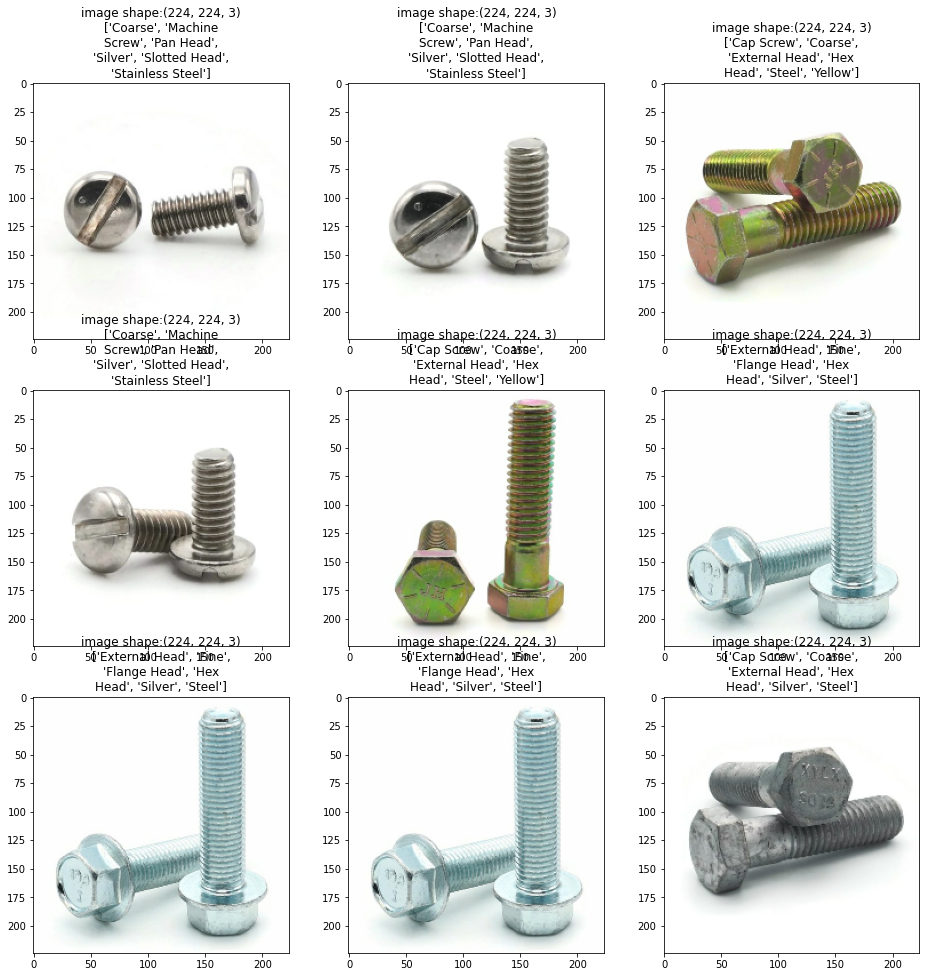

In [17]:
from textwrap import wrap

def show_samples(dataset):
  plt.subplots_adjust(hspace=2.5)
  fig=plt.figure(figsize=(16, 16))
  columns = 3
  rows = 3
  print(columns*rows,"samples from the dataset")
  i=1
  for a,b in dataset.take(columns*rows): 
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.squeeze(a))
    plt.title('\n'.join(wrap("image shape:"+ str(a.shape)+" "+ 
              str(covert_onehot_string_labels(LABELS,b.numpy())), 25)))
    i=i+1
  plt.show()
show_samples(ds_test)

In [18]:
#buffer_size = ds_train_resize_scale.cardinality().numpy()/10
#ds_resize_scale_batched=ds_raw.repeat(3).shuffle(buffer_size=buffer_size).batch(64, )

ds_train_batched=ds_train.batch(BATCH_SIZE).cache().prefetch(tf.data.experimental.AUTOTUNE) 
ds_test_batched=ds_test.batch(BATCH_SIZE).cache().prefetch(tf.data.experimental.AUTOTUNE)

print("Number of batches in train: ", ds_train_batched.cardinality().numpy())
print("Number of batches in test: ", ds_test_batched.cardinality().numpy())

Number of batches in train:  14
Number of batches in test:  4


In [58]:
# base_model = tf.keras.applications.VGG16(
#     weights='imagenet',
#     input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
#     include_top=False
# )
# base_model.trainable=False

In [19]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
effienct_v2 = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_s/classification/2"

feature_extractor_model = effienct_v2

In [20]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
    trainable=False
)

In [21]:
len(bin_df.to_numpy())

3798

In [22]:
num_classes = len(LABELS)

base_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
    feature_extractor_layer,
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(num_classes, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(num_classes, activation='sigmoid')
])
base_model.build((None,)+(IMG_WIDTH, IMG_HEIGHT, 3))

In [24]:
inputs = tf.keras.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
x = base_model(inputs, training=False)
# x = tf.keras.layers.GlobalAveragePooling2D()(x)
initializer = tf.keras.initializers.GlorotUniform(seed=42)

activation = tf.keras.activations.sigmoid
outputs = tf.keras.layers.Dense(num_classes, kernel_initializer=initializer, activation=activation)(x)
model = tf.keras.Model(inputs, outputs)

In [25]:
model.compile(
  optimizer=tf.keras.optimizers.Nadam(learning_rate=0.0005),
  loss=tf.keras.losses.BinaryCrossentropy(),
  metrics=[tf.keras.metrics.BinaryAccuracy()])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 91)                21711823  
_________________________________________________________________
dense_2 (Dense)              (None, 91)                8372      
Total params: 21,720,195
Trainable params: 107,835
Non-trainable params: 21,612,360
_________________________________________________________________


In [26]:
# model.fit(ds_train_batched, validation_data=ds_test_batched, epochs=100)

NUM_EPOCHS = 50

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss', min_delta=0.001, patience=3
)

history = model.fit(ds_train_batched,
                    validation_data=ds_test_batched,
                    epochs=NUM_EPOCHS,
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/50
14/14 [==============================] - 1442s 103s/step - loss: 0.6600 - binary_accuracy: 0.5939 - val_loss: 0.5645 - val_binary_accuracy: 0.7535
Epoch 2/50
14/14 [==============================] - 19s 1s/step - loss: 0.4894 - binary_accuracy: 0.8351 - val_loss: 0.4219 - val_binary_accuracy: 0.8852
Epoch 3/50
14/14 [==============================] - 19s 1s/step - loss: 0.3695 - binary_accuracy: 0.9140 - val_loss: 0.3309 - val_binary_accuracy: 0.9213
Epoch 4/50
14/14 [==============================] - 20s 1s/step - loss: 0.2955 - binary_accuracy: 0.9414 - val_loss: 0.2763 - val_binary_accuracy: 0.9338
Epoch 5/50
14/14 [==============================] - 20s 1s/step - loss: 0.2522 - binary_accuracy: 0.9441 - val_loss: 0.2441 - val_binary_accuracy: 0.9367
Epoch 6/50
14/14 [==============================] - 20s 1s/step - loss: 0.2258 - binary_accuracy: 0.9449 - val_loss: 0.2236 - val_binary_accuracy: 0.9369
Epoch 7/50
14/14 [==============================] - 20s 1s/step - loss: 

In [27]:
ds= ds_test_batched
print("Test Accuracy: ", model.evaluate(ds)[1])

4/4 [==============================] - 4s 951ms/step - loss: 0.1164 - binary_accuracy: 0.9591
Test Accuracy:  0.9591237306594849


In [28]:
ds=ds_test
predictions= model.predict(ds.batch(batch_size=50).take(1))
# print("A sample output from the last layer (model) ", predictions[0])
y=[]
print("10 Sample predictions:")
for (pred,(a,b)) in zip(predictions,ds.take(50)):
  pred[pred>0.5]=1
  pred[pred<=0.5]=0
  print("predicted: " , str(covert_onehot_string_labels(LABELS, pred)),  
        "Actual Label: ", str(covert_onehot_string_labels(LABELS,b.numpy())))
  y.append(b.numpy())

10 Sample predictions:
predicted:  ['Cap Screw', 'Coarse', 'External Head', 'Hex Head', 'Steel'] Actual Label:  ['Coarse', 'Machine Screw', 'Pan Head', 'Silver', 'Slotted Head', 'Stainless Steel']
predicted:  ['Coarse', 'External Head', 'Hex Head', 'Steel'] Actual Label:  ['External Head', 'Fine', 'Flange Head', 'Hex Head', 'Silver', 'Steel']
predicted:  ['Coarse', 'Silver'] Actual Label:  ['Coarse', 'Machine Screw', 'Pan Head', 'Silver', 'Slotted Head', 'Stainless Steel']
predicted:  ['Coarse', 'Hex Head', 'Silver', 'Stainless Steel'] Actual Label:  ['External Head', 'Fine', 'Flange Head', 'Hex Head', 'Silver', 'Steel']
predicted:  ['Coarse', 'Machine Screw'] Actual Label:  ['External Head', 'Fine', 'Flange Head', 'Hex Head', 'Silver', 'Steel']
predicted:  ['Coarse', 'External Head', 'Hex Head', 'Silver'] Actual Label:  ['Coarse', 'Machine Screw', 'Pan Head', 'Silver', 'Slotted Head', 'Stainless Steel']
predicted:  ['Coarse', 'External Head', 'Hex Head', 'Silver'] Actual Label:  ['Cap